# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Line Finding** 

## Camera Calibration

In [1]:
# import required libraries
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

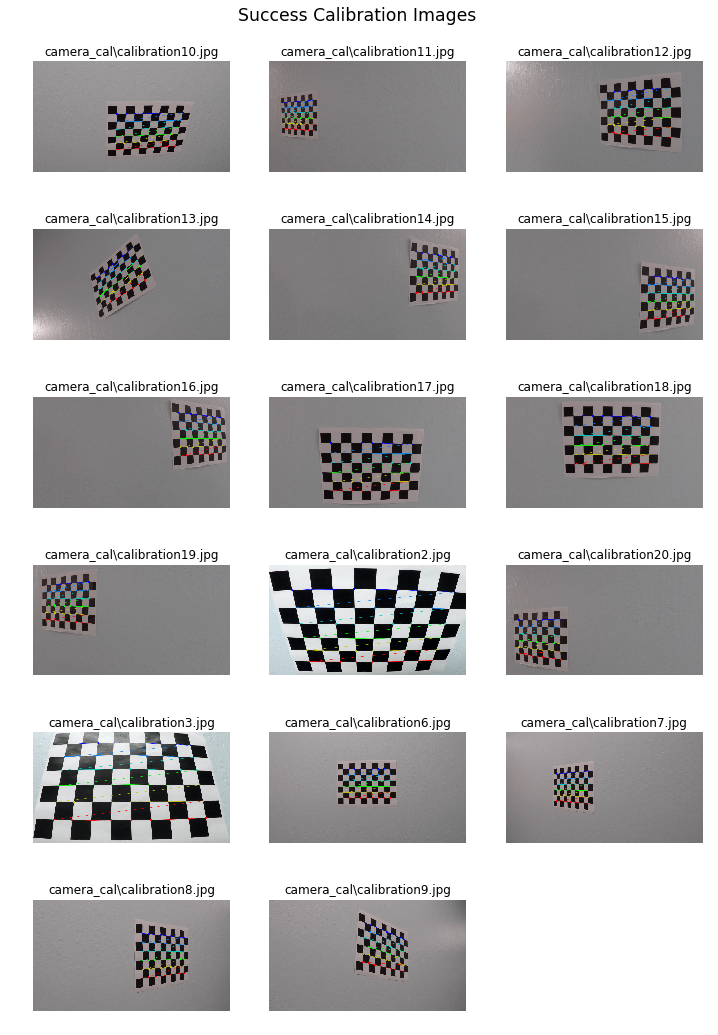

Success rate:  85.0 %


In [2]:
# Set up chessboard size to 9x6
x_chess = 9
y_chess = 6

# prepare objects points, like (0,0,0), (1,0,0), (2,0,0), ..., (6,5,0)
objp = np.zeros((y_chess*x_chess,3), np.float32)
objp[:,:2] = np.mgrid[0:x_chess, 0:y_chess].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of paths to calibration images
images = glob.glob('camera_cal/calibration*.jpg') 

# Calibration images that was failed to find corners
not_found = []

# plot the result
plt.figure(figsize=(12, 18))
plt.figtext(0.5, 0.9, "Success Calibration Images", size='xx-large', ha='center')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (x_chess, y_chess), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (x_chess, y_chess), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
    else:
        not_found.append(fname)
plt.show()

print("Success rate: ", str(len(imgpoints) * 100.0 / len(images)), "%")

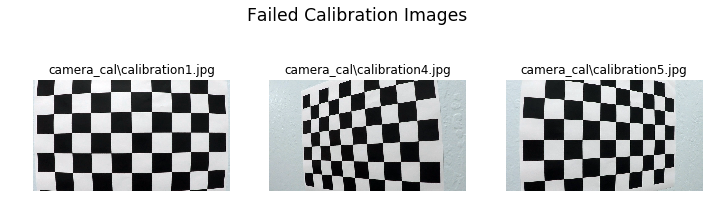

Fail rate:  15.0 %


In [3]:
plt.figure(figsize=(12, 4))
plt.figtext(0.5, 0.9, "Failed Calibration Images", size='xx-large', ha='center')
for idx, fname in enumerate(not_found):
    img = cv2.imread(fname)
    plt.subplot(1, len(not_found), idx+1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
plt.show()
print("Fail rate: ", str(len(not_found) * 100.0 / len(images)), "%")

By using `cv2.findChessboardCorners`, 17 out of 20 (85%) calibration images was successfully recognized and only 3 out of 20 (15%) calibration images were failed to be processed by the algorithm to find 9x6 corners

## Distortion Correction

Apply undistortion to the provided image. In this section, I use distorted chess and road image as the input

In [34]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return cv2.undistort(img, mtx, dist, None, mtx)

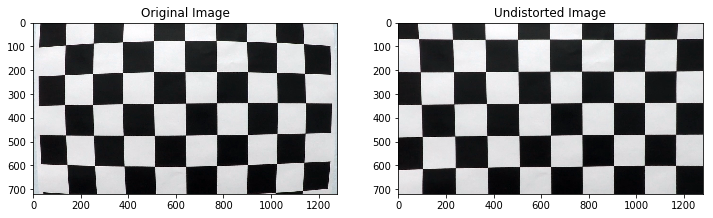

In [5]:
# Test undistortion on chessboard image
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
img = cv2.imread('camera_cal/calibration1.jpg')
plt.imshow(img)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted Image")

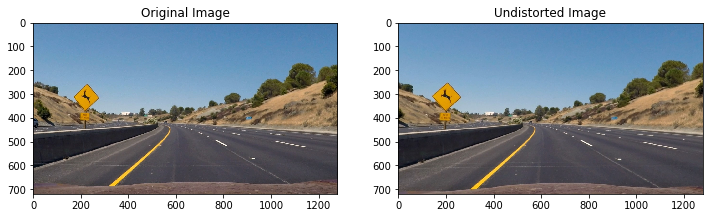

In [6]:
# Test undistortion on sample road image
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted Image")

## Color / Gradient Threshold

In this section, I provide various threshold function, from sobel, magnitude, direction, RGB, HLS, and combination one. The threshold that I use for this project is a combination between sobel, magnitude, direcction, and saturation.

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

In [8]:
def mag_threshold(img, sobel_kernel=9, thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(magnitude) / 255
    magnitude = (magnitude / scale_factor).astype(np.uint8)
    
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= thresh[0]) & (magnitude <= thresh[1])] = 1
    
    return binary_output

In [9]:
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_gradientx = np.absolute(sobelx)
    abs_gradienty = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_gradients = np.arctan2(abs_gradienty, abs_gradientx)
    
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_gradients)
    binary_output[(abs_gradients >= thresh[0]) & (abs_gradients <= thresh[1])] = 1
    
    return binary_output

In [10]:
def mag_dir_threshold_combined(img, mag_sobel_kernel=9, dir_sobel_kernel=15, mag_thresh=(30, 100), dir_thresh=(0.7, 1.3)):
    # Call Sobel Threshold to get the gradient x and y of sobel operator
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
    
    # Get the magnitude gradient
    mag_binary = mag_threshold(img, sobel_kernel=mag_sobel_kernel, thresh=(mag_thresh[0], mag_thresh[1]))
    
    # Get the direction gradient
    dir_binary = dir_threshold(img, sobel_kernel=dir_sobel_kernel, thresh=(dir_thresh[0], dir_thresh[1]))
    
    # Combine all of these gradients above together
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

In [11]:
def mag_dir_satur_thresh(img, sobel_kernel_x=3, sobel_kernel_y=3, dir_kernel=11, mag_kernel=11,
                        sobel_x_thresh=(20,100), sobel_y_tresh=(20,100), mag_thresh=(30,100), dir_thresh=(0.7, 1.3), sat_thresh=(25, 255)):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel_x, thresh=(sobel_x_thresh[0], sobel_x_thresh[1]))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=sobel_kernel_y, thresh=(sobel_y_tresh[0], sobel_y_tresh[1]))
    
    sat_binary = saturation_thresh(img, thresh=(sat_thresh[0], sat_thresh[1]))
    mag_binary = mag_threshold(img, sobel_kernel=mag_kernel, thresh=(mag_thresh[0], mag_thresh[1]))
    dir_binary = dir_threshold(img, sobel_kernel=dir_kernel, thresh=(dir_thresh[0], dir_thresh[1]))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sat_binary == 1)] = 1
    
    return combined

In [12]:
def blue_threshold(img, thresh=(25, 255)):
    blue = img[:,:,2]
    blue_binary = np.zeros_like(blue)
    blue_binary[(blue >= thresh[0]) & (blue <= thresh[1])] = 1
    return blue_binary

def green_threshold(img, thresh=(25, 255)):
    green = img[:,:,1]
    green_binary = np.zeros_like(green)
    green_binary[(green >= thresh[0]) & (green <= thresh[1])] = 1
    return green_binary

def red_threshold(img, thresh=(25, 255)):
    red = img[:,:,0]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh[0]) & (red <= thresh[1])] = 1
    return red_binary

In [13]:
def hue_thresh(img, thresh=(25, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hue = hls[:,:,0]
    hue_binary = np.zeros_like(hue)
    hue_binary[(hue > thresh[0]) & (hue <= thresh[1])] = 1
    return hue_binary

def lightness_thresh(img, thresh=(25, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lightness = hls[:,:,1]
    lightness_binary = np.zeros_like(lightness)
    lightness_binary[(lightness > thresh[0]) & (lightness <= thresh[1])] = 1
    return lightness_binary

def saturation_thresh(img, thresh=(25, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    saturation = hls[:,:,2]
    saturation_binary = np.zeros_like(saturation)
    saturation_binary[(saturation > thresh[0]) & (saturation <= thresh[1])] = 1
    return saturation_binary

In [14]:
def hist_normalization(img):
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])
    return img

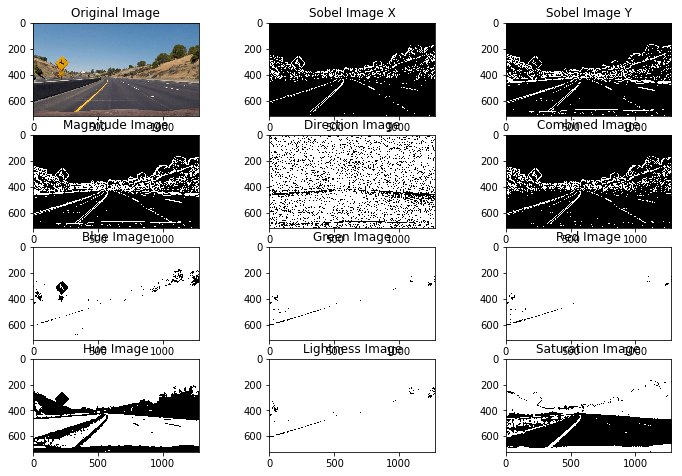

In [15]:
# Test each function
plt.figure(figsize=(12, 12))
img = mpimg.imread('test_images/test2.jpg')

plt.subplot(6, 3, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(6, 3, 2)
plt.imshow(abs_sobel_thresh(img, 'x', 11, (25,255)), cmap='gray')
plt.title("Sobel Image X")

plt.subplot(6, 3, 3)
plt.imshow(abs_sobel_thresh(img, 'y', 11, (25,255)), cmap='gray')
plt.title("Sobel Image Y")

plt.subplot(6, 3, 4)
plt.imshow(mag_threshold(img, 11, (25,255)), cmap='gray')
plt.title("Magnitude Image")

plt.subplot(6, 3, 5)
plt.imshow(dir_threshold(img, 11, (0.0, 1.4)), cmap='gray')
plt.title("Direction Image")

plt.subplot(6, 3, 6)
plt.imshow(mag_dir_threshold_combined(img, 11, 11, (25,255), (0.0,1.4)), cmap='gray')
plt.title("Combined Image")

plt.subplot(6, 3, 7)
plt.imshow(blue_threshold(img), cmap='gray')
plt.title("Blue Image")


plt.subplot(6, 3, 8)
plt.imshow(green_threshold(img), cmap='gray')
plt.title("Green Image")

plt.subplot(6, 3, 9)
plt.imshow(red_threshold(img), cmap='gray')
plt.title("Red Image")

plt.subplot(6, 3, 10)
plt.imshow(hue_thresh(img), cmap='gray')
plt.title("Hue Image")

plt.subplot(6, 3, 11)
plt.imshow(lightness_thresh(img), cmap='gray')
plt.title("Lightness Image")

plt.subplot(6, 3, 12)
plt.imshow(saturation_thresh(img), cmap='gray')
plt.title("Saturation Image")

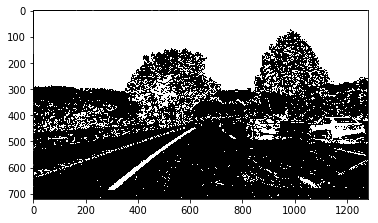

In [16]:
# Visualize an example by using a combination between sobel, magnitude, direction, and saturation threshold
img = mpimg.imread('test_images/test1.jpg')
# img = hist_normalization(img)
processed_img = mag_dir_satur_thresh(img, 3, 3, 11, 11, (20,100), (20,100), (30,100), (0.7,1.3), (100,255))
# processed_img = np.uint8(255 * processed_img / np.max(processed_img))
plt.imshow(processed_img, cmap='gray')

As we could see from each example of test unit for each threshold, I found out that this combined threshold could define quite a good result to recognize lane line.

# Transform Image

In this section, I'm using some technique that I learnt from the first project to determine the region of interest. After that, I use the result to transform it into bird-eye view.

In [17]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    vertices = np.array([
        [(0, img_size[1]-offset), (560, 450), (720, 450), (img_size[0], img_size[1]-offset)]
    ], dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [18]:
def perspective_transform(offset=50):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[0, img_size[1]-offset],
         [560, 450],
         [720, 450],
         [img_size[0], img_size[1]-offset]])
    dst = np.float32(
        [[200,img_size[1]],
         [200,0],
         [1160,0],
         [1160, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

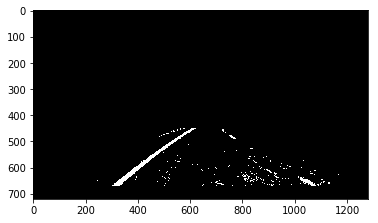

In [19]:
img_size = (img.shape[1], img.shape[0])
offset = 50

masked_image = region_of_interest(processed_img)
plt.imshow(masked_image, cmap='gray')

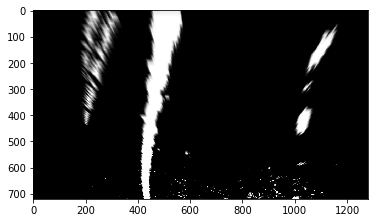

In [20]:
M, Minv = perspective_transform()
undist = undistort(masked_image)
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray')

## Detect Lane Lines

In [40]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def detect_lane_lines(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:, :], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped, warped, warped)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, ploty, left_fit_m, right_fit_m, left_fitx, right_fitx

(720, 0)

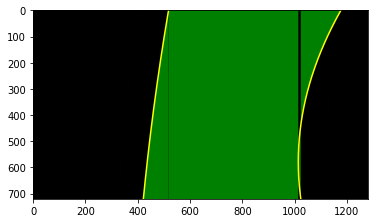

In [41]:
out_img, ploty, left_fit_m, right_fit_m, left_fitx, right_fitx = detect_lane_lines(warped)
fig = plt.figure()

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.fill_between(left_fitx, ploty, right_fitx, facecolor='green', interpolate=True)
plt.fill_between(left_fitx + ploty, ploty - right_fitx, right_fitx, where= ploty <= right_fitx-left_fitx, facecolor='green', interpolate=True)
plt.fill_between(right_fitx, ploty - right_fitx, ploty, facecolor='green', interpolate=True)
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0], 0)

## Determine The Lane Curvature

In [23]:
def calculate_lane_curvature(ploty, left_fit_m, right_fit_m, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    curvature = (left_curverad + right_curverad) / 2 
    center = (1.5 * left_curverad - right_curverad) / 2
    min_curvature = min(left_curverad, right_curverad)
    return left_curverad, right_curverad, center, curvature, min_curvature

In [24]:
left_curverad, right_curverad, center, curvature, min_curvature = calculate_lane_curvature(ploty, left_fit_m, right_fit_m, left_fitx, right_fitx)
print("Left lane curve radius: ", left_curverad)
print("Right lane curve radius: ", right_curverad)
print("Center: ", center)
print("Curvature: ", curvature)
print("Min. Curvature: ", min_curvature)

Left lane curve radius:  3470.26773018
Right lane curve radius:  4020.58530086
Center:  592.408147209
Curvature:  3745.42651552
Min. Curvature:  3470.26773018


## Apply To The Original Image

In [25]:
def apply_to_original_image(img, warped, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    return result

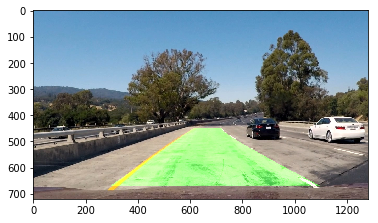

In [26]:
result = apply_to_original_image(img, warped, ploty, left_fitx, right_fitx, Minv)
plt.imshow(result)

## Stack Lane Detection Information

In [27]:
def add_figures_to_image(result, curvature, center, min_curvature):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param result:
    """
    curvature = curvature / 128 * 3.7
    min_curvature = min_curvature / 128 * 3.7
    center = center / 128 * 3.7
    
    x_axis = result.shape[1]*xm_per_pix
    centerImg = x_axis / 2
    vehicle_position = (center - centerImg) / 100
    
    if vehicle_position < 0:
        status = "left"
    else:
        status = "right"

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), status), (50, 100), font, 1,(255, 255, 255), 2)
    cv2.putText(result, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)

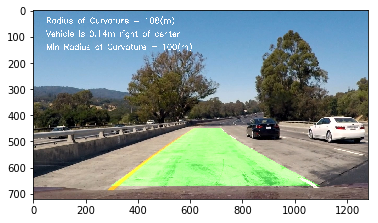

In [28]:
add_figures_to_image(result, curvature, center, min_curvature)
plt.imshow(result)

## Image Pipeline

In [35]:
# Initialize required hyperparameter(s)
offset = 50
M, Minv = perspective_transform()
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [36]:
def image_pipeline(file, isImage=False):
    # Clear the plot
    plt.clf()
    
    if isImage == True:
        inputFile = mpimg.imread(file)
    else:
        inputFile = file
    
    shape = (inputFile.shape[1], inputFile.shape[0])
    threshold_img = mag_dir_satur_thresh(inputFile, 3, 3, 11, 11, (20,100), (20,100), (30,100), (0.7,1.3), (100,255))
    roi_img = region_of_interest(threshold_img)
    undistort_img = undistort(roi_img)
    bird_eye_img = cv2.warpPerspective(undistort_img, M, shape, flags=cv2.INTER_LINEAR)
    out_img, ploty, left_fit_m, right_fit_m, left_fitx, right_fitx = detect_lane_lines(bird_eye_img)
    left_curverad, right_curverad, center, curvature, min_curvature = calculate_lane_curvature(ploty, left_fit_m, right_fit_m, left_fitx, right_fitx)
    result = apply_to_original_image(inputFile, bird_eye_img, ploty, left_fitx, right_fitx, Minv)
    add_figures_to_image(result, curvature, center, min_curvature)
    return result

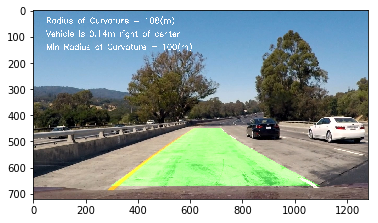

In [37]:
result = image_pipeline('test_images/test1.jpg', isImage=True)
plt.imshow(result)

## Video Pipeline

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
output = 'project_video_output.mp4'
input_clip = VideoFileClip('project_video.mp4')
output_clip = input_clip.fl_image(image_pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:51<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 22min 52s


In [324]:
output = 'challenge_video_output.mp4'
input_clip = VideoFileClip('challenge_video.mp4')
output_clip = input_clip.fl_image(image_pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [07:58<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 7min 58s


In [325]:
output = 'harder_challenge_video_output.mp4'
input_clip = VideoFileClip('harder_challenge_video.mp4')
output_clip = input_clip.fl_image(image_pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [20:30<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 20min 31s
